In [ ]:
import librosa
import glob
import os
import pandas as pd
import torch
import torchaudio
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import numpy as np
import librosa.display
# import importlib
# import seaborn as sns
from scipy.interpolate import UnivariateSpline
from useful_functions import plot_wav, plot_fft
import pickle
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.nn import init
import importlib
import scipy
import random
import sklearn
import resampy
import tqdm
import nlpaug
import nlpaug.augmenter.audio as naa
import torch.optim as optim
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import time

In [ ]:
#Defining some of the main parameters used in the project
SR = 4000
LENGTH = 8000
CUT_OFF_FREQ = 80
FILTER_ORDER = 6
N_MELS = 40

In [ ]:
path = "/mnt/c/Users/papch/OneDrive/Υπολογιστής/Σχολή/Internship-Thesis/ICBHI_final_database"
os.chdir(path)
os.getcwd()

'/mnt/c/Users/papch/OneDrive/Υπολογιστής/Σχολή/Internship-Thesis/ICBHI_final_database'

In [ ]:
icbhi = pd.read_csv("ICBHI_2017_Breath_Cycles.csv")

In [ ]:
#Creating multiple audio signal processing functions. A lot of them were not used after all
class AudioUtil():
    def open(df, index, sr):
        sig, sr = librosa.load(df.iloc[index][0], sr = sr, offset = df.iloc[index][1], duration = df.iloc[index][2] - df.iloc[index][1]) #audio = AudioUtil.open(icbhi.iloc[1][0], icbhi.iloc[1][1], icbhi.iloc[1][2]) to call it
        return (sig,sr)
    
    def resample(audio, newSR):
        sig, sr = audio
        
        if(sr == newSR):
            return audio

        resig = torchaudio.transforms.Resample(sr, newSR)(torch.from_numpy(sig))

        return (resig.numpy(), newSR)

    def high_pass_filter(audio, cut_off_freq, filter_order):
        sig, sr = audio

        nyquist = sr/2
       
        b, a = scipy.signal.butter(filter_order, cut_off_freq/nyquist, btype='highpass')

        output_signal = scipy.signal.filtfilt(b, a, sig)

        return(output_signal, sr)


    def zeropad(audio, length):
        sig, sr = audio
        max_len = int((length * sr)/1000)

        if (len(sig) >= max_len):
            new_sig = sig[:max_len]
        elif (len(sig) < max_len):
            pad_begin = random.randint(0,max_len - len(sig))
            pad_end = max_len-len(sig)-pad_begin
            new_sig= np.pad(sig, (pad_begin,pad_end), mode='constant')
            # new_sig = torch.cat(pad_begin, sig, pad_end)
        # elif (len(sig) < max_len):
        #     new_sig = np.empty(0)
        #     no_repeats = max_len // len(sig)
        #     end_pad = max_len - no_repeats*len(sig)
        #     for i in range(no_repeats):
        #         new_sig = np.concatenate([new_sig, sig])
            
        #     new_sig = np.concatenate([new_sig, sig[:end_pad]])


        if (torch.is_tensor(new_sig)):
            new_sig = new_sig.numpy()
            
        return (new_sig, sr)

    def interpolate(audio, length_ms):
        sig, sr = audio

        old_indices = np.arange(0, len(sig))
        new_length = (sr*length_ms)/1000
        new_indices = np.linspace(0, len(sig)-1, int(new_length))
        
        spl = UnivariateSpline(old_indices, sig, s=0)
        new_sig = spl(new_indices)
        return (new_sig, sr)

    def zero_and_interpol(audio, length):
        sig, sr = audio
        max_len = int((length*sr)/1000)

        if (len(sig) > max_len):
            old_indices = np.arange(0, len(sig))
            new_indices = np.linspace(0, len(sig)-1, int(max_len))

            spl = UnivariateSpline(old_indices, sig, s=0)
            new_sig = spl(new_indices)

        elif (len(sig) <= max_len):
            pad_begin = random.randint(0, max_len - len(sig))
            pad_end = max_len - len(sig) - pad_begin
            new_sig = np.pad(sig, (pad_begin, pad_end), mode = 'constant')

        return (new_sig, sr)


    def time_shift(audio, shift_limit):
        sig, sr = audio
        sig_len = len(sig)
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (np.roll(sig, shift_amt), sr)

    def hannWindow(audio, length, sr):
        sig, sr = audio
        window = np.hanning(len(sig))

        new_sig = (sig * window).astype(np.float32)
        return(new_sig, sr)


    def librosaMelSpectro(audio):
        sig, sr = audio

        mel_spectrogram = librosa.feature.melspectrogram(sig, sr=sr, n_fft=256, hop_length=128, n_mels=N_MELS)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        return log_mel_spectrogram

    def calculateMFCCS(spectro):
        mfccs = librosa.feature.mfcc(S=spectro, n_mfcc=40)
        return mfccs

    def calculateDeltaMFCCS(mfccs):
        delta_mfccs = librosa.feature.delta(mfccs)
        return delta_mfccs

    def calculateDelta2MFCCS(mfccs):
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        return delta2_mfccs

    def cwt(audio):
        sig, sr = audio
        coeff, _ = pywt.cwt(sig, range(1, 5), 'morl', sampling_period=1/sr)
        
        return coeff

    def normalization(audio):
        sig, sr = audio

        new_sig = (sig-min(sig))/(max(sig)-min(sig))
        # new_sig = (sig-np.mean(sig))/np.std(sig)

        return(new_sig, sr)

    def information_entropy(audio):
        sig, sr = audio

        # z = np.arange(min(sig), max(sig), 0.1)
        inst, bins = np.histogram(sig, range = (min(sig), max(sig)))
        ent_ppg = 0

        for i in range(len(inst)):
            if inst[i] != 0:
                p_z = inst[i]/sum(inst)
                ent_ppg = (-p_z)*math.log2(p_z) + ent_ppg
        
        return ent_ppg

    def masking(spec, n_time_masks, n_freq_masks):
        n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        spec_aug = spec

        freq_mask_limit = 0.1 * n_mels

        for _ in range(n_freq_masks):
            freq_mask_length = int(random.random() * freq_mask_limit)
            freq_mask_start = random.randint(0, n_mels)
            
            if ((freq_mask_start + freq_mask_length) < n_mels):
                spec_aug[freq_mask_start:freq_mask_start+freq_mask_length, :] = mask_value
            else:
                spec_aug[freq_mask_start:n_steps, :] = mask_value
        
        time_mask_limit = 0.1 * n_steps

        for _ in range(n_time_masks):
            time_mask_length = int(random.random() * time_mask_limit)
            time_mask_start = random.randint(0, n_steps)

            if ((time_mask_start + time_mask_length) < n_steps):
                spec_aug[:, time_mask_start:time_mask_start+time_mask_length] = mask_value
            else:
                spec_aug[:, time_mask_start:n_steps] = mask_value

        return spec_aug

    def feature_norm(feature):
        new_feat = (feature-glb_mean)/glb_std
        return new_feat

    def spectrogram_alternate(audio):
        audio, sr = audio

        frame_size = 0.025
        frame_stride = 0.01

        frame_length, frame_step = frame_size * sr, frame_stride * sr
        signal_length = len(audio)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(audio, z)

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]

        frames *= np.hamming(frame_length)

        NFFT = 512
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

        nfilt = 40

        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / sr)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
        filter_banks = 20 * np.log10(filter_banks)  # dB

        return filter_banks.T

In [ ]:
#Creating a butterwoth band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b,a, data)
    return y

In [ ]:
def Extract_Annotation_Data(file_name, data_dir):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient Number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(data_dir, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return recording_info, recording_annotations

# get annotations data and filenames
def get_annotations(data_dir):
	filenames = [s.split('.')[0] for s in os.listdir(data_dir) if '.wav' in s]
	i_list = []
	rec_annotations_dict = {}
	for s in filenames:
		i,a = Extract_Annotation_Data(s, data_dir)
		i_list.append(i)
		rec_annotations_dict[s] = a

	recording_info = pd.concat(i_list, axis = 0)
	recording_info.head()

	return filenames, rec_annotations_dict

In [ ]:
def get_sound_samples(recording_annotations, file_name, data_dir, sample_rate):
    sample_data = [file_name]
    # load file with specified sample rate (also converts to mono)
    data, rate = librosa.load(os.path.join(data_dir, file_name+'.wav'), sr=sample_rate)
    data, rate = AudioUtil.normalization((data, rate))
    # data, rate = AudioUtil.high_pass_filter((data, rate), CUT_OFF_FREQ, FILTER_ORDER)
    data = butter_bandpass_filter(data, 80, 1800, sample_rate)
    #print("Sample Rate", rate)
    
    for i in range(len(recording_annotations.index)):
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk, start,end, get_label(crackles, wheezes)))
    return sample_data

In [ ]:
#Segment audio samples into breath cycles
def slice_data(start, end, raw_data, sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
#Returning the label of each breath cycle
def get_label(crackle, wheeze):
    if crackle == 0 and wheeze == 0:
        return 0
    elif crackle == 1 and wheeze == 0:
        return 1
    elif crackle == 0 and wheeze == 1:
        return 2
    else:
        return 3

In [ ]:
#Padding the samples to the specific window length chosen
def generate_padded_samples(original, source, output_length, sample_rate):
    copy = np.zeros(output_length, dtype=np.float32)
    src_length = len(source)
    pad = output_length-src_length 

    prob= random.random()
    aug = original

    while len(aug) < pad:
        aug = np.concatenate([aug,aug])

    if prob < 0.5:
        copy[pad:] = source
        copy[:pad] = aug[len(aug)-pad:]
    else:
        copy[:src_length] = source[:]
        copy[src_length:] = aug[:pad]
    
    return copy

In [ ]:
#Choosing the correct padding of each cycle
def split_and_pad(original, desiredLength, sample_rate):
    output_buffer_length = int(desiredLength*sample_rate/1000)
    soundclip = original[0].copy()
    n_samples = len(soundclip)

    output = []

    # if: the audio sample length > desiredLength, then split & pad
	# else: simply pad according to given type 1 or 2
    if n_samples > output_buffer_length:
        frames = librosa.util.frame(soundclip, frame_length=output_buffer_length, hop_length=output_buffer_length//2, axis=0)
        for i in range(frames.shape[0]):
            output.append((frames[i], original[1]))

        last_id = frames.shape[0]*(output_buffer_length//2)
        last_sample = soundclip[last_id:]
        padded = generate_padded_samples(soundclip, last_sample, output_buffer_length, sample_rate)
        output.append((padded, original[1]))

    else:
        padded = generate_padded_samples(soundclip, soundclip, output_buffer_length, sample_rate)
        output.append((padded, original[1]))

    return output

In [ ]:
#Applying some data augmentation techniques on the audio samples using the nlpaug library
def gen_augmented(original, sample_rate):
    augment_list = [
        naa.NoiseAug(),
        naa.SpeedAug(),
        naa.LoudnessAug(factor=(0.5,2)),
        naa.VtlpAug(sampling_rate=sample_rate, zone=(0.0,1.0)),
        naa.PitchAug(sampling_rate=sample_rate, factor=(-1,3))
    ]

    aug_idx = random.randint(0, len(augment_list)-1)
    augmented_data = augment_list[aug_idx].augment(original)
    return augmented_data

In [ ]:
#Rolling the audio
def rollAudio(audio):
    pivot = np.random.randint(audio.shape[0])
    rolled_audio = np.roll(audio, pivot, axis=0)
    assert audio.shape[0] == rolled_audio.shape[0], "Roll audio shape mismatch"
    return rolled_audio

In [ ]:
#Creating the dataset
class DS(Dataset):
    def __init__(self, df, data_path, is_train, aug_scale):
        self.df = pd.read_csv(df)
        self.data_path = data_path
        self.sr = SR
        self.length = LENGTH
        self.channels = 1
        self.cutoff_freq = CUT_OFF_FREQ
        self.filter_order = FILTER_ORDER
        self.shift_limit = 0.4
        self.hop_length = 128
        self.is_train = is_train

        self.audio_data = []
        self.cycle_list = []
        self.classwise_cycle_list = [[], [], [], []]

        _, rec_annotations_dict = get_annotations(data_path)

        filenames = []

        if is_train:
            with open("ICBHI_challenge_train_test.txt") as file:
                lines = file.readlines()
                file.close()
                lines = [line.rstrip().split() for line in lines]
                for line in lines:
                    if line[1] == 'train':
                        filenames.append(line[0])
        else:
            with open("ICBHI_challenge_train_test.txt") as file:
                lines = file.readlines()
                file.close()
                lines = [line.rstrip().split() for line in lines]
                for line in lines:
                    if line[1] == 'test':
                        filenames.append(line[0])


        for idx, file_name in tqdm.tqdm(enumerate(filenames)):
            data = get_sound_samples(rec_annotations_dict[file_name], file_name, data_path, self.sr)
            for i in range(len(data[1:])):
                self.cycle_list.append((data[i+1][0], data[i+1][3]))
                self.classwise_cycle_list[data[i+1][3]].append(data[i+1][0])
        
        # for i in range(len(self.df)):
        #     data = AudioUtil.open(self.df, i, self.sr)
        #     data = AudioUtil.high_pass_filter(data, self.cutoff_freq, self.filter_order)
        #     label = self.df.iloc[i][3]
        #     self.cycle_list.append((data[0], label))
        #     self.classwise_cycle_list[self.df.iloc[i][3]].append(data[0])

        if is_train and aug_scale:
            self.increase_data(scale=aug_scale)

        for _, sample in enumerate(self.cycle_list):
            output = split_and_pad(sample, self.length, self.sr)
            self.audio_data.extend(output)
            

    #Creating new samples for augmenting the training data - Concatenating already existing samples
    def increase_data(self, scale=1):
        #augment normal
        aug_nos = scale*len(self.classwise_cycle_list[0]) - len(self.classwise_cycle_list[0])
        for idx in range(aug_nos):
            # normal_i + normal_j
            i = random.randint(0, len(self.classwise_cycle_list[0])-1)
            j = random.randint(0, len(self.classwise_cycle_list[0])-1)
            normal_i = self.classwise_cycle_list[0][i]
            normal_j = self.classwise_cycle_list[0][j]
            new_sample = np.concatenate([normal_i, normal_j])
            self.cycle_list.append((new_sample, 0))

        # augment crackle
        aug_nos = scale*len(self.classwise_cycle_list[0]) - len(self.classwise_cycle_list[1])
        for idx in range(aug_nos):
            aug_prob = random.random()

            if aug_prob < 0.6:
                # crackle_i + crackle_j
                i = random.randint(0, len(self.classwise_cycle_list[1])-1)
                j = random.randint(0, len(self.classwise_cycle_list[1])-1)
                sample_i = self.classwise_cycle_list[1][i]
                sample_j = self.classwise_cycle_list[1][j]
            elif aug_prob >= 0.6 and aug_prob < 0.8:
                # crackle_i + normal_j
                i = random.randint(0, len(self.classwise_cycle_list[1])-1)
                j = random.randint(0, len(self.classwise_cycle_list[0])-1)
                sample_i = self.classwise_cycle_list[1][i]
                sample_j = self.classwise_cycle_list[0][j]
            else:
                # normal_i + crackle_j
                i = random.randint(0, len(self.classwise_cycle_list[0])-1)
                j = random.randint(0, len(self.classwise_cycle_list[1])-1)
                sample_i = self.classwise_cycle_list[0][i]
                sample_j = self.classwise_cycle_list[1][j]

            new_sample = np.concatenate([sample_i, sample_j])
            self.cycle_list.append((new_sample, 1))

        # augment wheeze
        aug_nos = scale*len(self.classwise_cycle_list[0]) - len(self.classwise_cycle_list[2])
        for idx in range(aug_nos):
            aug_prob = random.random()

            if aug_prob < 0.6:
                # wheeze_i + wheeze_j
                i = random.randint(0, len(self.classwise_cycle_list[2])-1)
                j = random.randint(0, len(self.classwise_cycle_list[2])-1)
                sample_i = self.classwise_cycle_list[2][i]
                sample_j = self.classwise_cycle_list[2][j]
            elif aug_prob >= 0.6 and aug_prob < 0.8:
                # wheeze_i + normal_j
                i = random.randint(0, len(self.classwise_cycle_list[2])-1)
                j = random.randint(0, len(self.classwise_cycle_list[0])-1)
                sample_i = self.classwise_cycle_list[2][i]
                sample_j = self.classwise_cycle_list[0][j]
            else:
                # normal_i + wheeze_j
                i = random.randint(0, len(self.classwise_cycle_list[0])-1)
                j = random.randint(0, len(self.classwise_cycle_list[2])-1)
                sample_i = self.classwise_cycle_list[0][i]
                sample_j = self.classwise_cycle_list[2][j]

            new_sample = np.concatenate([sample_i, sample_j])
            self.cycle_list.append((new_sample, 2))

        # augment both
        aug_nos = scale*len(self.classwise_cycle_list[0]) - len(self.classwise_cycle_list[3])
        for idx in range(aug_nos):
            aug_prob = random.random()

            if aug_prob < 0.5:
                # both_i + both_j
                i = random.randint(0, len(self.classwise_cycle_list[3])-1)
                j = random.randint(0, len(self.classwise_cycle_list[3])-1)
                sample_i = self.classwise_cycle_list[3][i]
                sample_j = self.classwise_cycle_list[3][j]
            elif aug_prob >= 0.5 and aug_prob < 0.7:
                # crackle_i + wheeze_j
                i = random.randint(0, len(self.classwise_cycle_list[1])-1)
                j = random.randint(0, len(self.classwise_cycle_list[2])-1)
                sample_i = self.classwise_cycle_list[1][i]
                sample_j = self.classwise_cycle_list[2][j]
            elif aug_prob >=0.7 and aug_prob < 0.8:
                # wheeze_i + crackle_j
                i = random.randint(0, len(self.classwise_cycle_list[2])-1)
                j = random.randint(0, len(self.classwise_cycle_list[1])-1)
                sample_i = self.classwise_cycle_list[2][i]
                sample_j = self.classwise_cycle_list[1][j]
            elif aug_prob >=0.8 and aug_prob < 0.9:
                # both_i + normal_j
                i = random.randint(0, len(self.classwise_cycle_list[3])-1)
                j = random.randint(0, len(self.classwise_cycle_list[0])-1)
                sample_i = self.classwise_cycle_list[3][i]
                sample_j = self.classwise_cycle_list[0][j]
            else:
                # normal_i + both_j
                i = random.randint(0, len(self.classwise_cycle_list[0])-1)
                j = random.randint(0, len(self.classwise_cycle_list[3])-1)
                sample_i = self.classwise_cycle_list[0][i]
                sample_j = self.classwise_cycle_list[3][j]

            new_sample = np.concatenate([sample_i, sample_j])
            self.cycle_list.append((new_sample, 3))

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        audio, class_id = self.audio_data[idx]
        
        aug_prob = random.random()
        if aug_prob and self.is_train:
            audio = gen_augmented(audio, self.sr)
            audio = split_and_pad((audio, class_id), self.length, self.sr)[0][0]


        roll_prob = random.random()
        if roll_prob and self.is_train:
            audio = rollAudio(audio)


        #Extracting the log-Mel Spectrogram (we have also used the MFCCS, the extraction of them can be seen below)
        spectro = AudioUtil.librosaMelSpectro((audio, self.sr))
        mfccs = AudioUtil.calculateMFCCS(spectro)
        mfccs2 = AudioUtil.calculateDeltaMFCCS(mfccs)
        mfccs3 = AudioUtil.calculateDelta2MFCCS(mfccs2)
        
        return(torch.from_numpy(spectro)[None,:], class_id)
        # return(torch.from_numpy(np.concatenate((mfccs,mfccs2,mfccs3), axis=0))[None,:], class_id)

In [ ]:
#Creating our Hybrid CNN-LSTM model and also adding some quantization stubs that will be needed later

class Combine2(nn.Module):
    def __init__(self):
        super(Combine2, self).__init__()
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )

        self.rnn = nn.LSTM(
            input_size = 288, #288:Spectro, 1248: 40 MFCCS"
            hidden_size = 64,
            num_layers = 1,
            batch_first = True)

        self.linear = nn.Linear(64, 4)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
    
    
    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dequant(x)

        batch_size,  C, H, W = x.size()
        timesteps = W
    
        x = x.contiguous()
        r_in = x.view(batch_size, W, -1)
        h0 = torch.zeros(1, r_in.size(0), 64).to(device)
        c0 = torch.zeros(1, r_in.size(0), 64).to(device)
        r_out, (h_n, h_c) = self.rnn(r_in, (h0, c0))
        r_out2 = self.linear(r_out[:, -1, :])
        
        return r_out2

In [ ]:
max_icbhi = 0

In [ ]:
#Creating the training function and editing it so that it can show us the ICBHI Score and the correct predictions after each epoch
def training(model, train_dl, val_dl, num_epochs):
    global max_icbhi
    criterion = nn.CrossEntropyLoss()
    # criterion = FocalLoss(weight = weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
    # optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        training_loss = 0.0
        validation_loss = 0.0
        correct_prediction = 0
        val_correct_prediction = 0
        total_prediction = 0
        val_total_prediction = 0
        correct = [0] * 4
        total = [0] * 4 


        model.train()

        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            # inputs, labels = data[0], data[1]
            inputs = inputs.float()

            # #z-normalization (may be deleted)
            # inputs_m, inputs_s = inputs.mean(), inputs.std()
            # inputs = (inputs - inputs_m) / inputs_s

            # #min-max normalization
            # inputs_max, inputs_min = inputs.max(), inputs.min()
            # inputs = (inputs - inputs_min)/(inputs_max-inputs_min)

            optimizer.zero_grad()

            output_train = model(inputs)

            loss_train = criterion(output_train, labels)

            loss_train.backward()
            optimizer.step()

            training_loss += loss_train.item()

            _, prediction = torch.max(output_train, 1)
            
            correct_prediction += (prediction==labels).sum().item()
            total_prediction += prediction.shape[0]


        model.eval()

        with torch.no_grad():
            for data in val_dl:
                val_inputs, val_labels = data[0].to(device), data[1].to(device)
                # val_inputs, val_labels = data[0], data[1]
                val_inputs = val_inputs.float()

                #normalization (may be deleted)
                # inputs_m, inputs_s = val_inputs.mean(), val_inputs.std()
                # val_inputs = (val_inputs - inputs_m) / inputs_s
                
                # #min max normalization
                # inputs_max, inputs_min = val_inputs.max(), val_inputs.min()
                # val_inputs = (val_inputs - inputs_min)/(inputs_max-inputs_min)

                val_outputs = model(val_inputs)

                loss_val = criterion(val_outputs, val_labels)
                validation_loss += loss_val.item()

                _, prediction = torch.max(val_outputs, 1)
                
                val_correct_prediction += (prediction==val_labels).sum().item()
                val_total_prediction += prediction.shape[0]
                
                for j in range(len(val_labels)):
                    if val_labels[j] == 0:
                        total[0] += 1
                        if prediction[j] == 0:
                            correct[0] += 1
                    elif val_labels[j] == 1:
                        total[1] += 1
                        if prediction[j] == 1:
                            correct[1] += 1
                    elif val_labels[j] == 2:
                        total[2] += 1
                        if prediction[j] == 2:
                            correct[2] += 1
                    elif val_labels[j] == 3:
                        total[3] += 1
                        if prediction[j] == 3:
                            correct[3] += 1

        #predicting stats at the end of every epoch
        num_batches = len(train_dl)
        num_val_batches = len(val_dl)
        avg_loss = training_loss / num_batches
        val_loss = validation_loss / num_val_batches
        train_losses.append(avg_loss)
        test_losses.append(val_loss)

        accuracy = correct_prediction/total_prediction
        val_accuracy = val_correct_prediction/val_total_prediction
        sensitivity = (correct[1]+correct[2]+correct[3]) / (total[1]+total[2]+total[3])
        specificity = correct[0] / total[0]
        icbhi_score = (sensitivity + specificity) / 2
        print(total)
        print(correct)
        print(f'Epoch: {epoch+1}, Loss: {avg_loss:.3f}, Validation Loss: {val_loss:.3f}, Training Accuracy: {accuracy:.3f}, Validation Accuracy{val_accuracy:.3f}, Sensitivity{sensitivity:.3f}, Specificity{specificity:.3f}, ICBHI 2017 Score: {icbhi_score:.3f}')

        if icbhi_score > max_icbhi:
            max_icbhi = icbhi_score
            torch.save(model.state_dict(), "/mnt/c/Users/papch/OneDrive/Υπολογιστής/Σχολή/Internship-Thesis/model_to_quantize__16092022.pth")

    
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)

    # np.save("train_losses.npy", train_losses)
    # np.save("test_losses.npy", test_losses)

    print('Finished Training')
    return train_losses, test_losses

In [ ]:
#creating the inference function, similar to the training one, will be used just to get results once
def inference(model, test_dl):
    import warnings
    warnings.filterwarnings("ignore")


    model.eval()
    predictions = []
    total_labels = []

    correct = [0] * 4
    total = [0] * 4
    correct_predictions = 0
    total_predictions = 0

    # start = time.time()
    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            total_labels.extend(labels)

            # inputs_m, inputs_s = inputs.mean(), inputs.std()
            # inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)

            _, prediction = torch.max(outputs, 1)
    
    # end = time.time()
    # print("INFERENCE TIME: ", end-start)
            predictions.extend(prediction)

            correct_predictions += (prediction==labels).sum().item()
            total_predictions += prediction.shape[0]

            for j in range(len(labels)):
                if labels[j] == 0:
                    total[0] += 1
                    if prediction[j] == 0:
                        correct[0] += 1
                elif labels[j] == 1:
                    total[1] += 1
                    if prediction[j] == 1:
                        correct[1] += 1
                elif labels[j] == 2:
                    total[2] += 1
                    if prediction[j] == 2:
                        correct[2] += 1
                elif labels[j] == 3:
                    total[3] += 1
                    if prediction[j] == 3:
                        correct[3] += 1

    accuracy = correct_predictions/total_predictions

    sensitivity = (correct[1]+correct[2]+correct[3]) / (total[1]+total[2]+total[3])
    specificity = correct[0] / total[0]
    icbhi_score = (sensitivity + specificity) / 2
    
    print(total)
    print(correct)
    print(f'Test Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}, ICBHI Score: {icbhi_score:.3f}')
    return(total_labels, predictions)

In [ ]:
#Creating the training and testing sets using functions already written above
train_ds = DS("ICBHI_Breath_Cycles_Train.csv", path, is_train=1, aug_scale=1)
test_ds = DS("ICBHI_Breath_Cycles_Test.csv", path, is_train=0, aug_scale=0)

539it [04:45,  1.89it/s]
381it [03:00,  2.11it/s]


In [ ]:
#Failed attempt to create a Temporal Convolutional Network (TCN) 
from torch.nn.utils import weight_norm


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNModel(nn.Module):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            1, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(num_channels[-1], 4)

    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))

In [ ]:
#Creating the dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
# val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [ ]:
#Initializing the model and choosing the correct device (CPU or GPU)
model = Combine2()
# model = TCNModel([20] * 3, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
next(model.parameters()).device

device(type='cpu')

In [ ]:
#IF YOU WANT TO TRAIN THE MODEL (NEW)
train_losses, test_losses = training(model, train_dl, test_dl, 150)
print("MAX ICBHI SCORE IS:", max_icbhi)
# inference(model, test_dl)
np.save("train_losses1.npy", train_losses, allow_pickle=True)
np.save("test_losses1.npy", test_losses, allow_pickle=True)
np.save("train_losses2.npy", train_losses, allow_pickle=False)
np.save("test_losses2.npy", test_losses, allow_pickle=False)

[1579, 649, 388, 145]
[631, 350, 120, 7]
Epoch: 1, Loss: 1.228, Validation Loss: 1.330, Training Accuracy: 0.438, Validation Accuracy0.401, Sensitivity0.404, Specificity0.400, ICBHI 2017 Score: 0.402
[1579, 649, 388, 145]
[494, 475, 116, 23]
Epoch: 2, Loss: 1.034, Validation Loss: 1.316, Training Accuracy: 0.541, Validation Accuracy0.401, Sensitivity0.519, Specificity0.313, ICBHI 2017 Score: 0.416
[1579, 649, 388, 145]
[812, 281, 139, 17]
Epoch: 3, Loss: 0.969, Validation Loss: 1.283, Training Accuracy: 0.573, Validation Accuracy0.452, Sensitivity0.370, Specificity0.514, ICBHI 2017 Score: 0.442
[1579, 649, 388, 145]
[880, 358, 101, 18]
Epoch: 4, Loss: 0.931, Validation Loss: 1.175, Training Accuracy: 0.596, Validation Accuracy0.491, Sensitivity0.404, Specificity0.557, ICBHI 2017 Score: 0.480
[1579, 649, 388, 145]
[432, 387, 143, 56]
Epoch: 5, Loss: 0.891, Validation Loss: 1.667, Training Accuracy: 0.610, Validation Accuracy0.369, Sensitivity0.496, Specificity0.274, ICBHI 2017 Score: 0.

In [ ]:
# np.save("train_losses.npy", train_losses)
# np.save("test_losses.npy", test_losses)

In [ ]:
#If you want to load the already trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normal = Combine2()
normal.load_state_dict(torch.load("/mnt/c/Users/papch/OneDrive/Υπολογιστής/Σχολή/Internship-Thesis/model_to_quantize_13092022.pth"))

normal = normal.to(device)
next(normal.parameters()).device

labels, predictions = inference(normal, test_dl)

[1579, 649, 388, 145]
[1252, 215, 71, 18]
Test Accuracy: 0.5636, Sensitivity: 0.257, Specificity: 0.793, ICBHI Score: 0.525


In [ ]:
for i in range(len(predictions)):
    predictions[i] = predictions[i].item()

In [ ]:
for i in range(len(labels)):
    labels[i] = labels[i].item()

In [ ]:
import sklearn

In [ ]:
cfm = sklearn.metrics.confusion_matrix(labels, predictions)

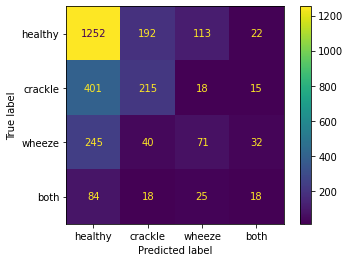

In [ ]:
cfmPlot = sklearn.metrics.ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'crackle', 'wheeze', 'both'])
cfmPlot.plot()
plt.show()

From now on we implement the quantization of the model.

First part includes the dynamic quantization of the LSTM and Linear segment of the model.

Second part includes the static quantzation of the CNN segment of the model.

We can observe that after the quantization and reduction of the model size and inference time, the results are still quite good.

In [ ]:
#LSTM AND LINEAR DYNAMIC QUANTIZATION
from torch.quantization import quantize_dynamic
quantized_int8 = quantize_dynamic(
    model=normal, qconfig_spec={nn.LSTM, nn.Linear}, dtype=torch.qint8, inplace=False
)

In [ ]:
labels2, predictions2 = inference(quantized_int8, test_dl)

[1579, 649, 388, 145]
[1235, 217, 76, 16]
Test Accuracy: 0.5592, Sensitivity: 0.261, Specificity: 0.782, ICBHI Score: 0.522


In [ ]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [ ]:
print_size_of_model(normal, label="normal")

model:  normal  	 Size (KB): 673.108


673108

In [ ]:
print_size_of_model(quantized_int8, label="quant")

model:  quant  	 Size (KB): 403.342


403342

In [ ]:
quantized_int8.eval()

Combine2(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): DynamicQuantizedLSTM(288, 64, batch_first=True)
  (linear): DynamicQuantizedLinear(in_features=64, out_features=4, dtype=torch.qint8, qscheme=torch.per_tenso

In [ ]:
fused = torch.quantization.fuse_modules(quantized_int8, [['conv1.0', 'conv1.2', 'conv1.1']])
fused = torch.quantization.fuse_modules(quantized_int8, [['conv2.0', 'conv2.2', 'conv2.1']])
fused = torch.quantization.fuse_modules(quantized_int8, [['conv3.0', 'conv3.2', 'conv3.1']])

In [ ]:
quantized_int8.qconfig = torch.quantization.get_default_qconfig("fbgemm")
torch.quantization.prepare(quantized_int8, inplace=True)

Combine2(
  (conv1): Sequential(
    (0): Conv2d(
      1, 32, kernel_size=(5, 5), stride=(1, 1)
      (activation_post_process): HistogramObserver()
    )
    (1): ReLU()
    (2): BatchNorm2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): HistogramObserver()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(
      32, 64, kernel_size=(3, 3), stride=(1, 1)
      (activation_post_process): HistogramObserver()
    )
    (1): ReLU()
    (2): BatchNorm2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): HistogramObserver()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(
      64, 96, kernel_size=(3, 3), stride=(1, 1)
      (activation_post_process): HistogramObserver()
    )
    (1): ReLU()
    (2): BatchNorm

In [ ]:
calibration_set = []

for i in range(100):
    calibration_set.append(next(iter(train_dl)))

In [ ]:
from random import randrange

with torch.inference_mode():
    for data in calibration_set:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.float()

        results = quantized_int8(inputs)

In [ ]:
torch.quantization.convert(quantized_int8, inplace=True)

Combine2(
  (conv1): Sequential(
    (0): QuantizedConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), scale=2.6870713233947754, zero_point=70)
    (1): ReLU()
    (2): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): QuantizedConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.7143712043762207, zero_point=96)
    (1): ReLU()
    (2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): QuantizedConv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), scale=1.5027791261672974, zero_point=73)
    (1): ReLU()
    (2): QuantizedBatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [ ]:
labels3, predictions3 = inference(quantized_int8, test_dl)

[1579, 649, 388, 145]
[1191, 193, 96, 17]
Test Accuracy: 0.5422, Sensitivity: 0.259, Specificity: 0.754, ICBHI Score: 0.507


In [ ]:
print_size_of_model(quantized_int8, label="quant")

model:  quant  	 Size (KB): 188.562


188562